In [2]:
import pandas as pd
import numpy as np
import nmslib

%load_ext autoreload
%autoreload 2
from matrix_factorization import Matrix_Factorization_V2

import seaborn as sns
import matplotlib.pylab as plt

# init value: set -200 as out of range value
OUT_OF_RANGE_RSSI = -200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VBD DATA

In [3]:
beacons = ['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006']
def preprocess_data(raw_data='training-vbd-floor1.json', beacons=beacons):
    rawdata_vbd_df = pd.read_json('training-vbd-floor1.json')
    data = []
    row_data = []
    for cell in rawdata_vbd_df.data.beacons:
        row_data = []
        row_data.append(cell['Y'])
        row_data.append(cell['X'])
        for beacon in beacons:
            row_data.append(int(cell[beacon]))
        data.append(row_data)
    columns = ['col', 'row'] + beacons
    # convert to dataframe
    rssi_dataset_df = pd.DataFrame(data, columns=columns)
    return rssi_dataset_df

# convert to dataframe
rssi_dataset_df = preprocess_data()

## Split train set & test set

In [11]:

training_data = rssi_dataset_df.sample(frac=0.9, random_state=10)
testing_data = rssi_dataset_df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 72
No. of testing examples: 8


# MATRIX FACTORIZATION V2 

## Helper functions: get predict & test radiomap 

In [12]:
def get_one_beacon(dataset=training_data, beacon='Beacon00001'):
    beacon_data = dataset[['col','row',beacon]].copy()
    # rename columns
    beacon_data.rename(columns={beacon:'rssi'}, inplace=True)
    return beacon_data

def get_mf_model(training_data_single, testing_data_single):
    # prepare data
    rate_train = training_data_single.to_numpy()
    rate_test = testing_data_single.to_numpy()

    # # indices start from 0
    # rate_train[:, :2] -= 1
    # rate_test[:, :2] -= 1

    rs = Matrix_Factorization_V2(rate_train, K = 4, lam = 0.01, print_every = 100000, 
        learning_rate = 0.01, max_iter = 10000, user_based = 1)
    rs.fit()
    # evaluate on test data
    RMSE = rs.evaluate_RMSE(rate_test)
    print ('\nUser-based MF, RMSE test =', RMSE)

    return rs

def get_test_mtx(training_data_single, testing_data_single):
    # init test matrix
    n_rows = int(training_data_single.row.max())+1
    n_cols = int(training_data_single.col.max())+1
    radiomap_test = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
    radiomap_test[testing_data_single.row, testing_data_single.col] = testing_data_single.rssi

    return radiomap_test

def plot_radiomap(radiomap, min_data, max_data, beacon):
    sns.color_palette("flare", as_cmap=True)
    ax = sns.heatmap(radiomap, cmap="flare",  vmin=min_data, vmax=max_data)
    plt.title(f"Radiomap: {beacon}")
    plt.xlabel('x-index (1m x 1m square)', fontsize = 10)
    plt.ylabel('y-index (1m x 1m square)', fontsize = 10)
    plt.show()

## Generating RadioMap


User-based MF, RMSE test = 0.18757923634361315


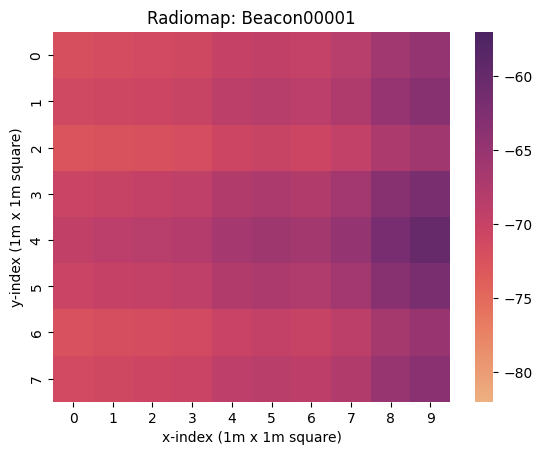


User-based MF, RMSE test = 2.6560944061129357


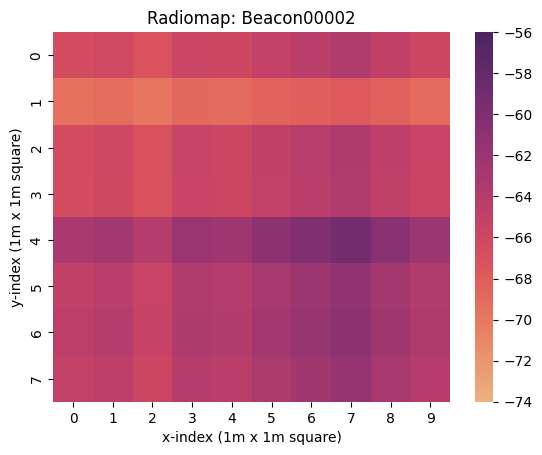


User-based MF, RMSE test = 0.285681799271683


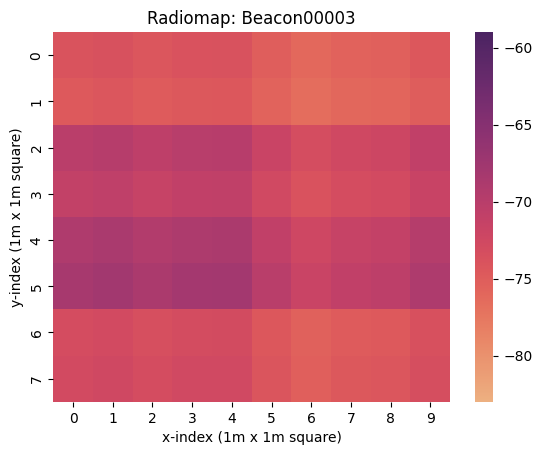


User-based MF, RMSE test = 0.11862289092078847


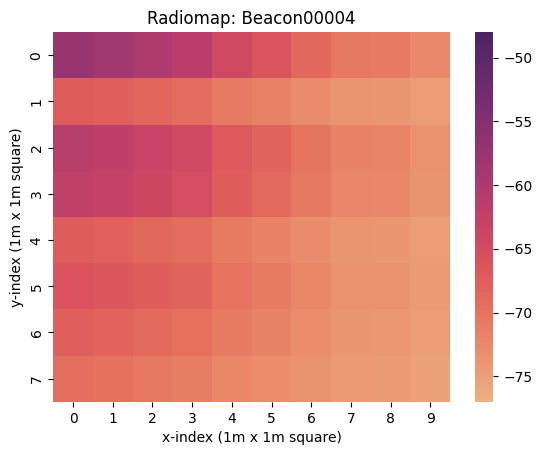


User-based MF, RMSE test = 0.3006379998017266


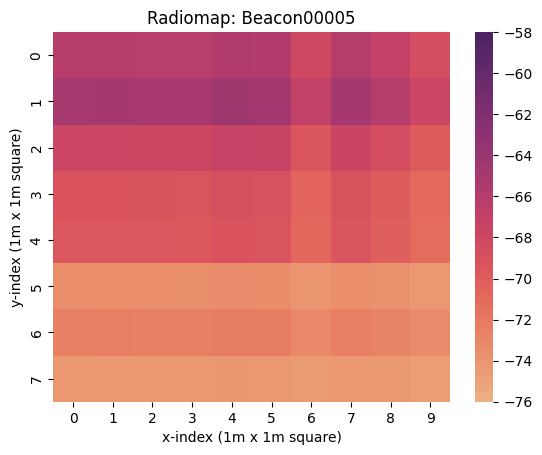


User-based MF, RMSE test = 0.2601970302971939


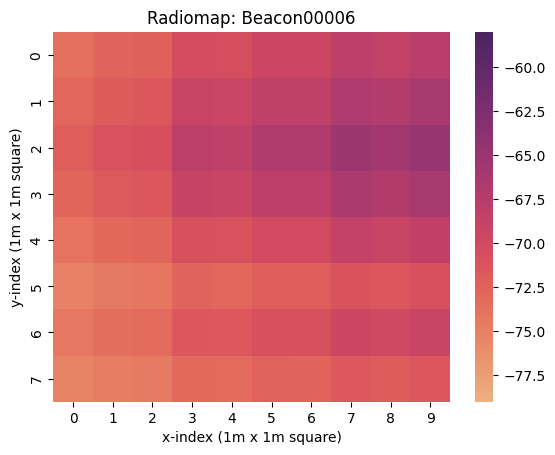

In [13]:
radiomaps = []
radiomaps_test = []
for beacon in beacons:
    training_data_single = get_one_beacon(dataset=training_data, beacon=beacon)
    testing_data_single = get_one_beacon(dataset=testing_data, beacon=beacon)
    rs = get_mf_model(training_data_single, testing_data_single)
    test_mtx = get_test_mtx(training_data_single, testing_data_single)
    # plot Raw & MF radiomap
    plot_radiomap(rs.get_pred_mtx(), rs.min_data, rs.max_data,beacon=beacon)
    # append radiomap for every beacon into list
    radiomaps.append(rs.get_pred_mtx().flatten())
    radiomaps_test.append(test_mtx.flatten())

## Build search space for indoor positioning

In [14]:
def get_fingerprints(radiomaps):
    data = []
    flatten_size = len(radiomaps[0])
    for cell in range(flatten_size):
        fingerprint = []
        for radiomap in radiomaps:
            fingerprint.append(radiomap[cell])
        # if not np.isin(OUT_OF_RANGE_RSSI, fingerprint):
        #     data.append(fingerprint)
        data.append(fingerprint)
    return data

def flatten_to_cell(nrow, ncol, id):
    col = id % ncol
    row = id//ncol
    return row,col

In [15]:
testing_data.head()

,col,row,Beacon00001,Beacon00002,Beacon00003,Beacon00004,Beacon00005,Beacon00006
0,8,1,-64,-63,-71,-77,-69,-56
8,5,0,-64,-200,-66,-68,-58,-68
9,6,0,-65,-65,-64,-72,-56,-66
15,2,1,-69,-71,-73,-64,-65,-73
28,6,2,-62,-63,-68,-68,-66,-61


Measurement position: (1,8)
Predict 3 nearest neighbours: ([(2, 9), (3, 9), (2, 8)])


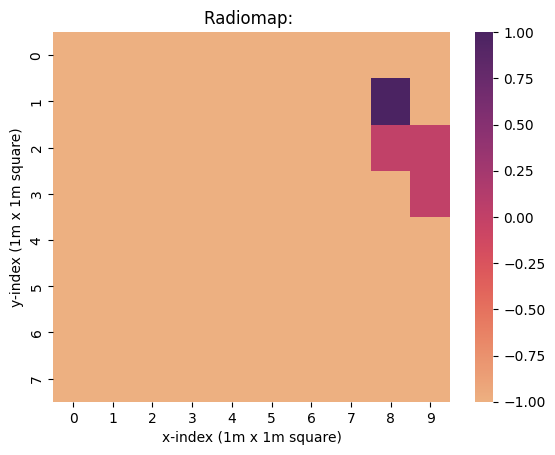

Measurement position: (0,5)
Predict 3 nearest neighbours: ([(1, 2), (1, 4), (1, 3)])


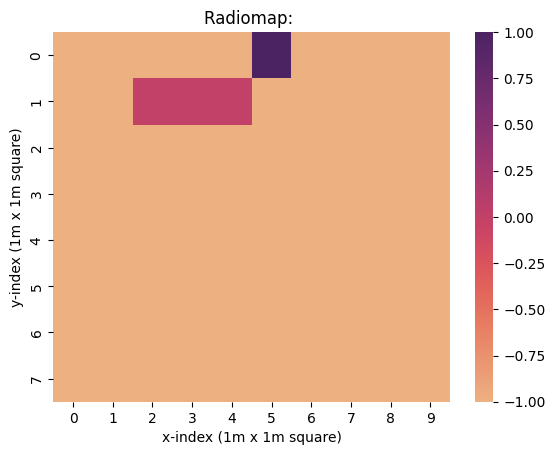

Measurement position: (0,6)
Predict 3 nearest neighbours: ([(1, 4), (1, 5), (1, 7)])


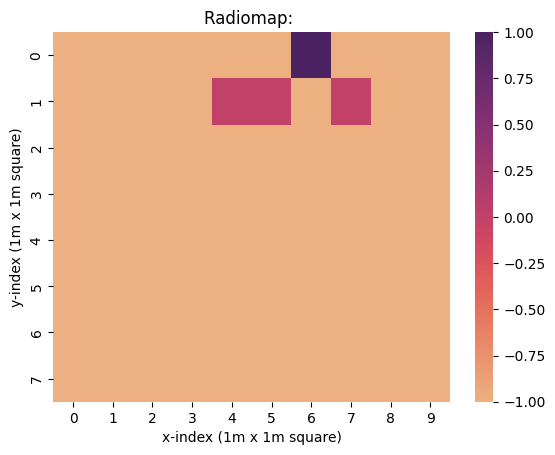

Measurement position: (1,2)
Predict 3 nearest neighbours: ([(1, 0), (1, 1), (1, 2)])


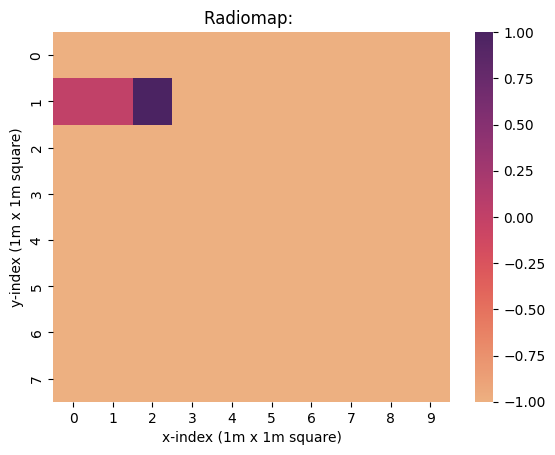

Measurement position: (2,6)
Predict 3 nearest neighbours: ([(2, 9), (2, 8), (3, 7)])


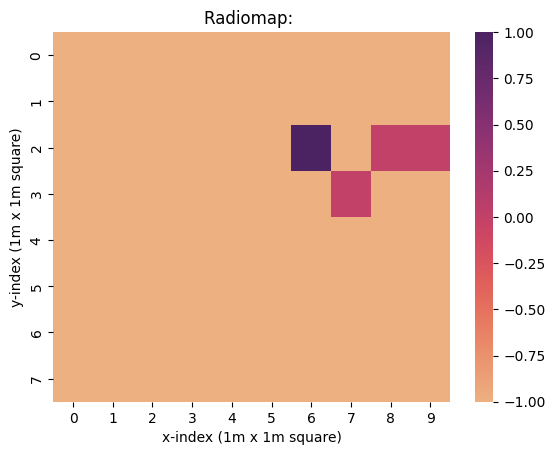

Measurement position: (2,7)
Predict 3 nearest neighbours: ([(2, 8), (2, 9), (2, 7)])


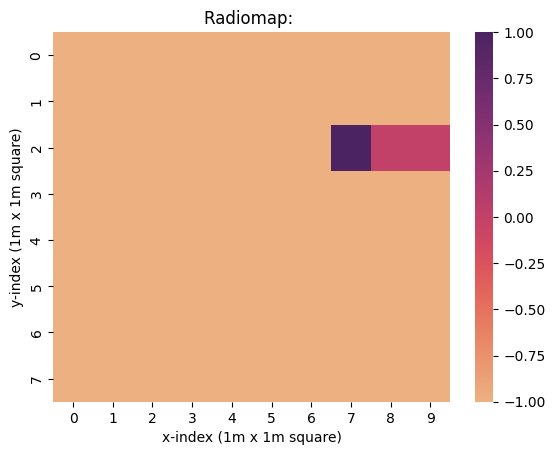

Measurement position: (6,2)
Predict 3 nearest neighbours: ([(3, 4), (3, 3), (5, 2)])


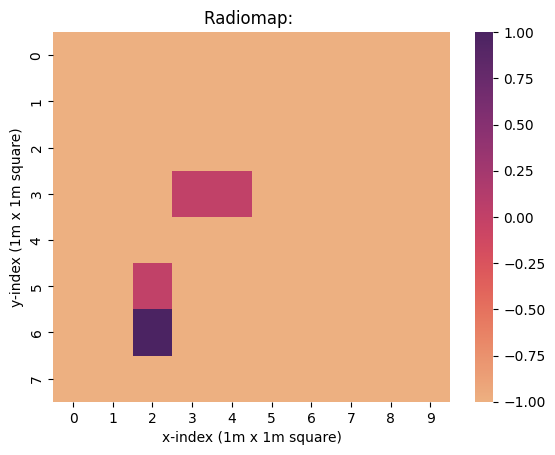

Measurement position: (7,2)
Predict 3 nearest neighbours: ([(7, 3), (7, 1), (7, 0)])


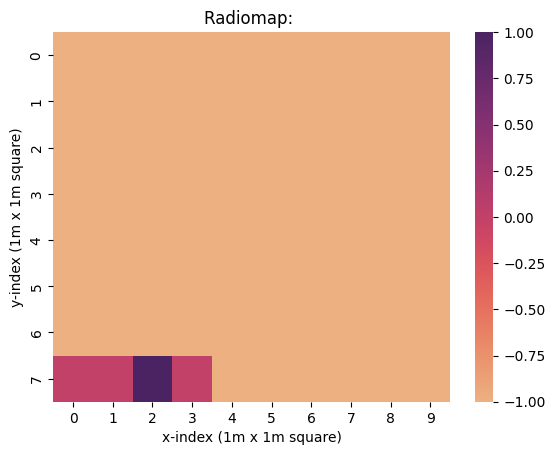

In [16]:
n_rows = training_data.max()['row']+1
n_cols = training_data.max()['col']+1

data = get_fingerprints(radiomaps=radiomaps)
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)



for idx,rdata in testing_data.iterrows():
    # prepare for plot
    location_map = np.full((n_rows, n_cols), -1)

    # query for the nearest neighbours of the first datapoint
    ids, distances = index.knnQuery(rdata[2:].values, k=3)
    cells = list(map(lambda idx: flatten_to_cell(nrow=n_rows,ncol=n_cols, id=idx),ids))
    
    # fill in into radiomap
    for cell in cells:
        location_map[cell[0],cell[1]] = 0

    col_idx = rdata['col']
    row_idx = rdata['row']
    # fill in into radiomap
    location_map[row_idx, col_idx] = 1
    print(f'Measurement position: ({row_idx},{col_idx})')
    print(f'Predict 3 nearest neighbours: ({cells})')
    # print(f'Distances: {distances}')
    
    # plot location map
    plot_radiomap(location_map,min_data=-1,max_data=1,beacon='')
    print('===================')